# Spatial Optimization Problems

* solutions are based on minimizing or maximizing an objective function while operating within a set of constraints
* there are several methods, e.g.,
    * exact techniques such as __linear programming__
    * heuristic-based approaches such as __greedy algorithms__ and __genetic algorithms__
* here, we cover three types of problems:
    * Location Set Covering Problem (LSCP)
    * Traveling Salesperson Problem (TSP)
    * Capacitated Vehicle Routing Problem (CVRP)



 
__Learning Objectives:__
* identify spatial optimization problems
* program objective functions and constraints to identify optimal solutions
* interface with the Google Maps API for Python

### Some Background

__Linear Programming__
* method to get to an optimal solution of a problem by solving a linear equation
* key concepts:
    * __Objective Function:__ the goal / problem you are actually trying to solve (e.g. maximize profit, minimize loss, optimize space allocation).
    * --Constraints:-- what can or cannot not happen while you’re solving the problem (e.g. value can’t be negative, max space available in a container)
    * --Variables:-- the variable parts of your problem (e.g. products, prices, profit, size)


__Greedy algorithms__
* make locally optimal choices and are often used for simpler spatial optimization problems where efficiency is crucial.

__Genetic algorithms__
* take inspiration from natural evolution and are employed for complex spatial optimization problems where a global search across a vast solution space is required

__Solver__
* tool or library that is used to find the optimal solution to a linear programming problem
* takes the linear programming problem as input, including the objective function and constraints, and compute the optimal values of the decision variables that maximize or minimize the objective function while satisfying the constraints
* choice of solver depends on the specific problem, the scale of the problem, and other requirements, such as integer variables or specialized constraints

## Setup

In [1]:
# Importing requisite packages
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

import numpy as np
import geopandas as gpd
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox

import warnings
warnings.filterwarnings('ignore')

/Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Configure the Solver
https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html#configuring-where-the-cmd-solvers-write-their-temporary-files

In [2]:
# check which solver pulp has acess to
solver_list = pulp.listSolvers()
print(solver_list)

solver_list_available = pulp.listSolvers(onlyAvailable=True)
solver_list_available

# Note: we need 'PULP_CBC_CMD' to be available. If not, uninstall from conda environment, then reinstall with pip


['GLPK_CMD', 'PYGLPK', 'CPLEX_CMD', 'CPLEX_PY', 'GUROBI', 'GUROBI_CMD', 'MOSEK', 'XPRESS', 'XPRESS', 'XPRESS_PY', 'PULP_CBC_CMD', 'COIN_CMD', 'COINMP_DLL', 'CHOCO_CMD', 'MIPCL_CMD', 'SCIP_CMD', 'HiGHS_CMD']


['PULP_CBC_CMD', 'COIN_CMD']

---

# 1. Location Set Covering Problem (LSCP)

* __Set covering problems:__ NP-hard (Non-deterministic Polynomial-time hard) problem within the __combination optimization__ space
    * __NP-hard problem__: a problem for which no known efficient algorithm exists that can guarantee a solution in polynomial time
* typically aim to minimizing the number of sets within a space that cover all the demand whtin that space
* e.g., optimizing emergency service facilities that service demand of all residents in a given cummuity
* _sevice time_ and _service distance_ can be contraints
* goal is to minimize the number of locations that service the demand points within a specified time period or service distance

## 1.1 Solving LSCPs
* _spopt_ module within PySal

__Problem:__
* 150 patients who need medical attention
* 4 medical centers from which you can serve them
* maximum service area for each hospital is 5,500 meters

In [3]:
## Define problem
patients = 150 # number of demand points represented as patients
medical_centers = 4 # number of service points represented as medical centers

service_area = 5500 # the max service area in meters; roughly 3.4 mi.

# Setting the random seeds for reproducibility
patient_seed = 54321
medical_centers_seed = 54321

# Setting up the solver
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

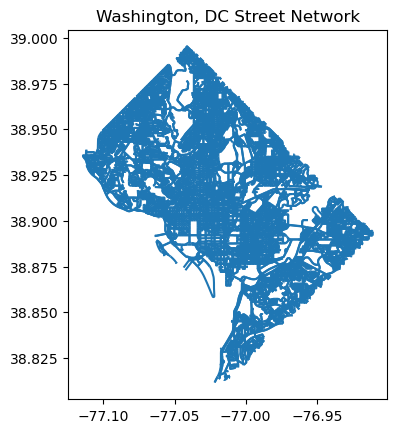

Text(0.5, 1.0, 'Subset used for analysis')

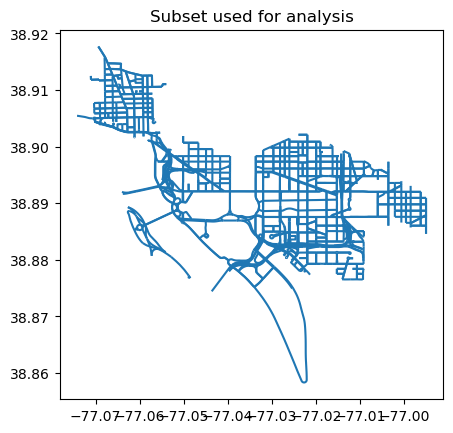

In [4]:
## Extracting the street network for Washington, DC from Open Street Map
G = ox.graph_from_place('Washington, DC', network_type='drive')

# Converting the network to a geopandas datafram of edges/lines and nodes/points
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.reset_index(inplace=True)

# Plotting the edges of the network
gdf_edges.plot()
plt.title("Washington, DC Street Network")
plt.show()


## Extracting subset
# Pulling the Washington, DC tracts from the Census Bureau
DC_BGs = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_11_bg.zip', compression='zip')

# Selecting a single tract withing Washington, DC to reduce computation time
DC_BGs_Sel = DC_BGs[DC_BGs['TRACTCE'].isin(['980000','010202','005900','000102','000202',
                                            '010800','005801','005802','010500','005602',
                                           '006600','008200'])]
# Dissolving the blockgroups into the single tract
DC_BGs_Sel_D = DC_BGs_Sel.dissolve()

# Setting the CRS
DC_BGs_Sel_D = DC_BGs_Sel_D.to_crs('EPSG:4326')
#DC_BGs_Sel_D.head()

# Subsetting the network
mask = gdf_edges.within(DC_BGs_Sel_D.loc[0,'geometry'])
gdf_edges_clipped = gdf_edges.loc[mask]
#gdf_edges_clipped.head()

# Plotting the clipped network
gdf_edges_clipped.plot()
plt.title("Subset used for analysis")

In [5]:
# Reducing the number of columns
gdf_edges_clipped = gdf_edges_clipped[['osmid','geometry']]

# Converting to the Albers projection
gdf_edges_clipped_p = gdf_edges_clipped.to_crs(5070)

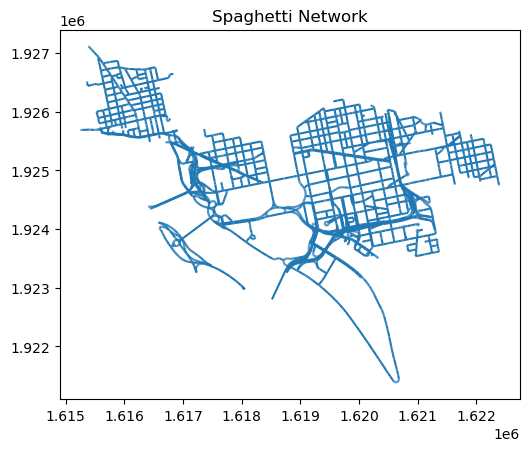

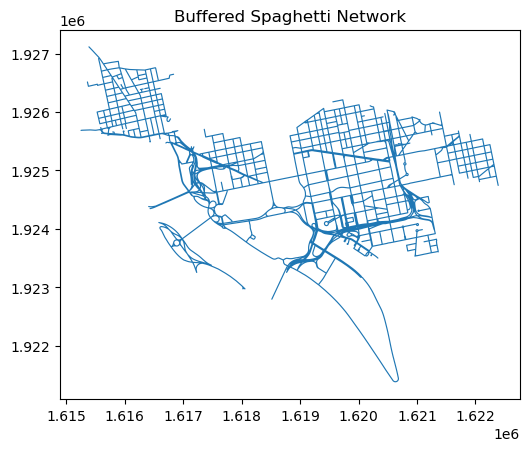

In [6]:
# Converting from geopandas to a spaghetti network
ntw =  spaghetti.Network(in_data=gdf_edges_clipped_p)

# Converting the spaghetti network into a GeoDataFrame
streets_gpd = spaghetti.element_as_gdf(ntw, arcs=True)

# Plotting the road network
streets_gpd.plot()
plt.title("Spaghetti Network")
plt.show()

# Creating a buffered version of the street network for use later
street_buffer = gpd.GeoDataFrame(
    gpd.GeoSeries(streets_gpd['geometry'].buffer(10).unary_union),
    crs=streets_gpd.crs,
    columns=['geometry']
)
# Plotting the buffered road network
street_buffer.plot()
plt.title("Buffered Spaghetti Network")
plt.show()

## 1.2 Simulate patients locations and medical center locations

In [7]:
# Simulating the patient locations
patient_locs = simulated_geo_points(street_buffer, 
                                    needed=patients, 
                                    seed=patient_seed)

# Simulating the medical center locations
medical_center_locs = simulated_geo_points(street_buffer, 
                                    needed=medical_centers, 
                                    seed=medical_centers_seed)

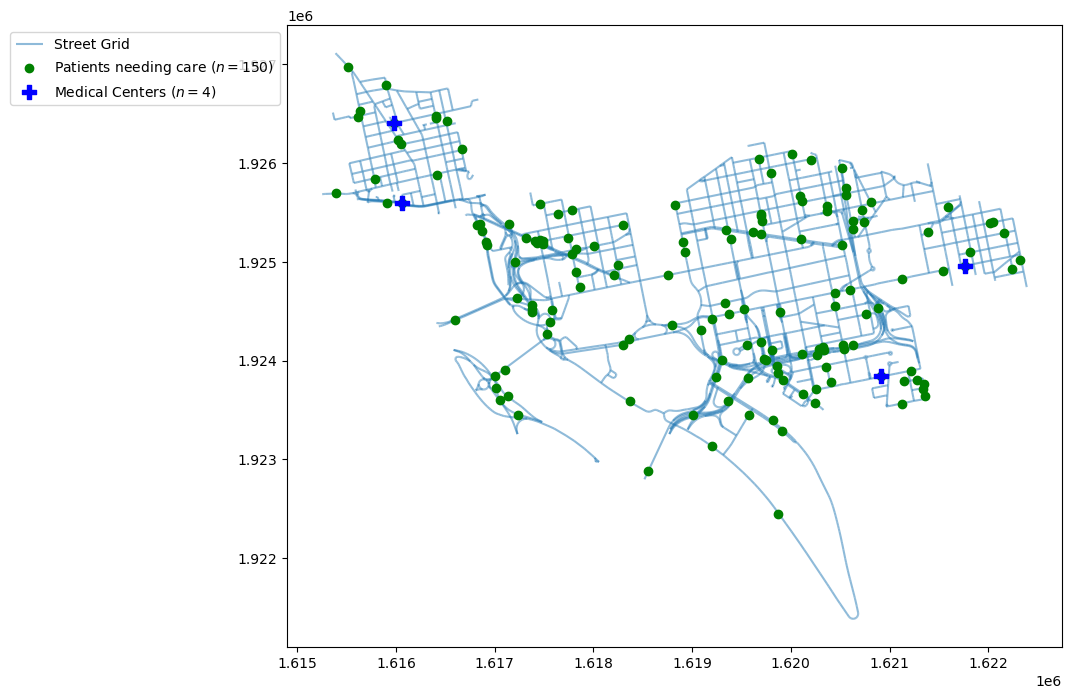

In [8]:
# Plotting the simulated points on the network
fig, ax = plt.subplots(figsize=(10,10))

streets_gpd.plot(ax=ax, alpha=0.5, zorder=1, label='Street Grid')
patient_locs.plot(ax=ax, color='green',zorder=2,label='Patients needing care ($n=$150)')
medical_center_locs.plot(ax=ax, markersize = 100, color='blue',marker="P",zorder=3,label='Medical Centers ($n=$4)')
plt.legend(loc='upper right', bbox_to_anchor=(0,1))

## 1.3 Associate the points to the network
* simulated points don't always fall perfectly onto street network
* points must be traversable
* __snapping:__ moves simulated pointss to the closest node on the network

In [9]:
# Snapping the patient locations
ntw.snapobservations(patient_locs,"patients",attribute=True)
patients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="patients", snapped = True
)

# Snapping the medical center locations
ntw.snapobservations(medical_center_locs,"medical_centers",attribute=True)
medical_centers_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="medical_centers", snapped = True
)

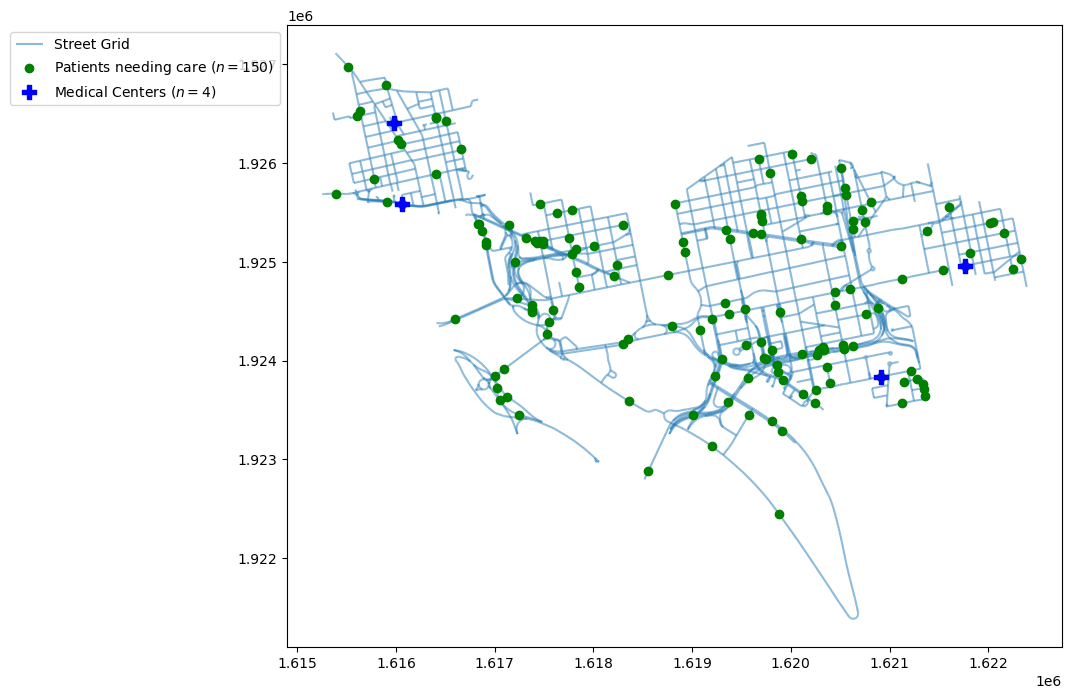

In [10]:
# Plotting the simulated points on the network
fig, ax = plt.subplots(figsize=(10,10))

streets_gpd.plot(ax=ax, alpha=0.5, zorder=1, label='Street Grid')
patients_snapped.plot(ax=ax, color='green',zorder=2,label='Patients needing care ($n=$150)')
medical_centers_snapped.plot(ax=ax, markersize = 100, color='blue',marker="P",zorder=3,label='Medical Centers ($n=$4)')
plt.legend(loc='upper right', bbox_to_anchor=(0,1))

## 1.4 Calculate the distance based cost matrix
* represents distance between each patient and medical center location

In [11]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["patients"],
    destpattern=ntw.pointpatterns["medical_centers"],
)

## 1.5 Solving the problem 
* pass cost matrix into PuLP solver to identify the optimal medical locations to serve all of the patient demand

In [12]:
# Find the solution to the LSCP using PuLP
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, service_area)
lscp_from_cost_matrix = lscp_from_cost_matrix.solve(solver)

# Convert to facility client array
lscp_from_cost_matrix.facility_client_array()

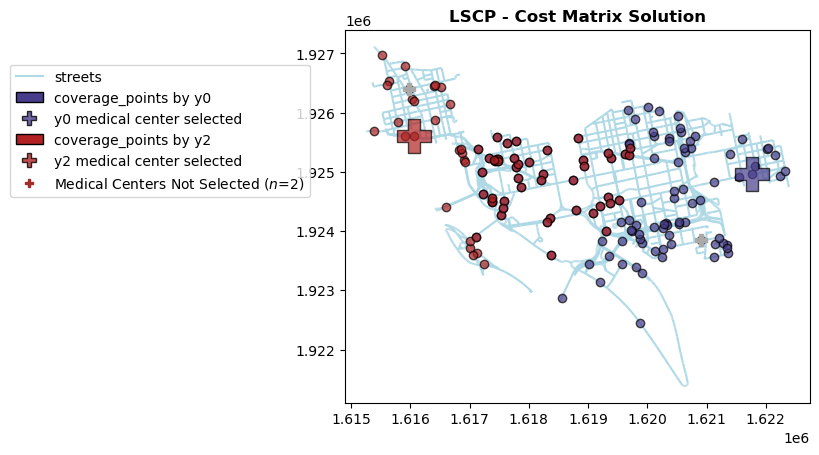

In [13]:
## Plot results to identify whtich medical centers were selected and what part of the pop they are serving
from matplotlib.patches import Patch
import matplotlib.lines as mlines

colors_arr = [
    "darkslateblue",
    "forestgreen",
    "firebrick",
    "peachpuff",
    "saddlebrown",
    "cornflowerblue"    
]

colors_ops = { f"y{i}":colors_arr[i] for i in range(len(colors_arr))}

serviced_points = []
selected_sites = []

for i in range(medical_centers):
    if lscp_from_cost_matrix.fac2cli[i]:

        geom = patient_locs.iloc[lscp_from_cost_matrix.fac2cli[i]]['geometry']
        serviced_points.append(geom)
        selected_sites.append(i)

# Plot the solution
fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

# Plot the street network
streets_gpd.plot(ax=ax, alpha=1, color='lightblue', zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='lightblue',
    label='streets',
))

for i in range(len(serviced_points)):
    gdf = gpd.GeoDataFrame(serviced_points[i])

    l = f"y{selected_sites[i]}"

    label = f"coverage_points by y{selected_sites[i]}"
    legend_elements.append(Patch(facecolor=colors_ops[l], edgecolor="k", label=label))

    gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=colors_ops[l], label=label)
    medical_center_locs.iloc[[selected_sites[i]]].plot(ax=ax,
                            marker="P",
                            markersize=150 * 4.0,
                            alpha=0.7,
                            zorder=4,
                            edgecolor="k",
                            facecolor=colors_ops[l])

    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=colors_ops[l],
        marker="P",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{selected_sites[i]} medical center selected",
    ))
    
# Plot locations of unselected medical centers
mc_not_selected = medical_center_locs.drop(selected_sites)
mc_not_selected.plot(ax=ax, color='darkgrey', marker="P", markersize=80, zorder=3)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='brown',
    marker="P",
    linewidth=0,
    label=f'Medical Centers Not Selected ($n$={len(mc_not_selected)})'
))


plt.title("LSCP - Cost Matrix Solution", fontweight="bold")
plt.legend(handles = legend_elements, loc='upper right', bbox_to_anchor=(0,1), borderaxespad=2.5)


Two medical centres can service all of the patient locations in this community.

___

## 2. Routing Problems

* __Route-based combinatorial optimization problems:__ set out to solve the most efficient rounte from point A to a set of destination points
    * points also referred to as __nodes__ (graph theory)
* __Traveling Salesperson Problem (TSP):__ one vehicle departs starting point and travels to a set of destination points, minimizing the distance traveled
* __Vehicle Rounting Problem (VRP):__ a set of vehicles can visit destinations, problem is to find optimal routes
* __Capacitated Vehicle Rounting Problem (CVRP):__ vehicles have a set capacity that can be loaded into them

In [14]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps
import ortools
import matplotlib.pyplot as plt

#### Setting up Google Maps API

* _gmaps_ and _googlemaps_ packages
* get API key from https://developers.google.com/maps

In [15]:
# Set API key
#c = Census("CENSUS API KEY HERE")

# import API key
import json
with open('../../_api_keys.json', 'r', encoding='utf-8') as f:
    api_keys = json.load(f)

print(api_keys.keys())

API_KEY = api_keys['google_maps']

dict_keys(['map_quest', 'google_maps', 'us_census'])


In [16]:
gmaps.configure(api_key=API_KEY)

from googlemaps import Client
client = Client(key=API_KEY)

### 2.1 Traveling Sales Person Problem

__Problem:__
* 15 customers that you need to deliver products in the most efficient manner from NY warehouse

In [17]:
## Set up dataset

# Setting the random seed for reproducibility
np.random.seed(seed=12345)

# Setting up the problem
customers = 15

# Setting the location of the warehouse
wh_lat = 40.749587
wh_lon = -73.985441

# Creating a synthetic dataset with demand points around the warehouse location
locs = pd.DataFrame({'latitude': np.random.normal(wh_lat, .008, customers),
                     'longitude': np.random.normal(wh_lon, .008, customers)
                    })

# Setting the warehouse as the 0th location
cols = ['latitude','longitude']
wh = pd.DataFrame([[wh_lat,wh_lon]], columns=cols)

# Creating a final dataset
data = pd.concat([wh, locs], ignore_index=True)

# Adding in labels
data.reset_index(inplace=True)
data.rename(columns={'index':'Label'}, inplace=True)
data['Label'] = data['Label'].astype(str)
data.at[0,'Label']='Warehouse'

# Adding in colors
data['colors'] = np.where(data['Label']=='Warehouse', "darkslateblue", "forestgreen")

data.head() 

Label   latitude  longitude         colors
0  Warehouse  40.749587 -73.985441  darkslateblue
1          1  40.747949 -73.978350    forestgreen
2          2  40.753419 -74.001454    forestgreen
3          3  40.745431 -73.988416    forestgreen
4          4  40.745141 -73.972089    forestgreen

Note that warehouse has to be at index 0 for algorithm to work.

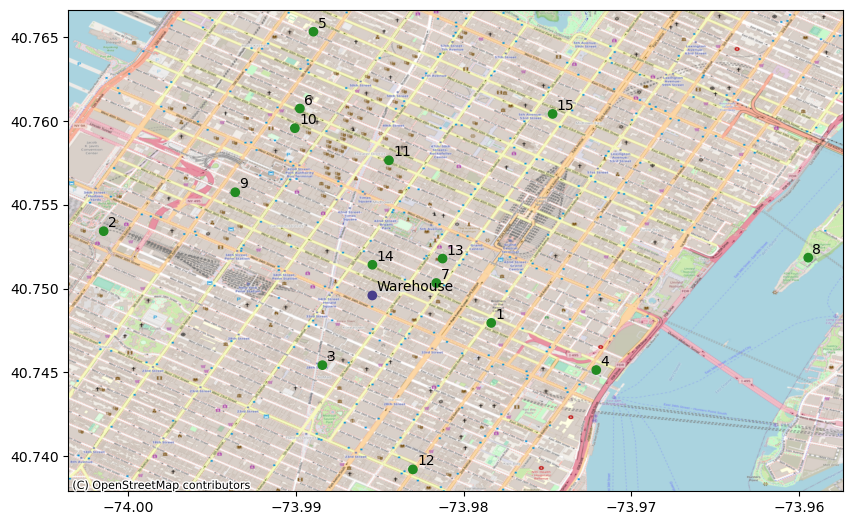

In [18]:
## Produce map of simulated data

import geopandas
import contextily

data_gdf = geopandas.GeoDataFrame(
    data, geometry=geopandas.points_from_xy(data.longitude, data.latitude, crs='EPSG:4326'))

f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    #source=contextily.providers.Stamen.Watercolor,
    source=contextily.providers.OpenStreetMap.Mapnik,
    zoom=16
)

for x, y, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.show()

#### Produce Origin-Destination Cost Matrtix (O-D Matrix)

* shows the distance between each point and all other points
* use Google Maps Directions API (mode='driving')

In [19]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000)

# Calculating the distances from Google Maps
distances = np.zeros((len(data_gdf),len(data_gdf)))
data_gdf['coord'] = '0'

for row in range(len(data_gdf)):
    data_gdf.at[row,'coord'] = str(data_gdf.latitude[row]) + "," + str(data_gdf.longitude[row])

for lat in range(len(data_gdf)):
    for lon in range(len(data_gdf)):

        # Call google maps api to calculate distances
        maps_api_result = client.directions(data_gdf['coord'].iloc[lat],
                                            data_gdf['coord'].iloc[lon],
                                            mode='driving')

        # append the distance to the distances df
        distances[lat][lon] = maps_api_result[0]['legs'][0]['distance']['value']   

# Converting array from float to int
dist_int = distances.astype(int)
        
# Display the distance array
print(np.matrix(dist_int))

[[    0  1312  2023  1483  1677  2811  2139   846  9016  1479  1729  1161  2194   955  1032  2097]
 [  713     0  2740  1307   676  3696  2915  1094  8016  2192  2441  1875  1193  1545   968  2347]
 [ 2859  3393     0  2224  3751  2701  2412  2926 11098  1752  2713  3243  3386  3037  3113  4176]
 [ 1118  1501  2655     0  1862  3780  3492  1498  9202  2832  2845  2278  1141  1948  1371  2751]
 [ 1488  1087  3515  2082     0  4294  3613  1868  8086  2966  3221  2652  2068  2319  1742  3121]
 [ 2718  2937  2472  3049  3608     0   666  2470  9251  1295  1286  1811  4210  2261  2657  1475]
 [ 2051  2269  2519  2365  2945  1386     0  1803  9541  1340  1008  1611  3461  1596  1990  1764]
 [  712   467  2738  1302  1143  2897  2221     0  8479  1560  1811  1245  1660   915   651  1717]
 [ 8709  8048 10728  9302  8238  9941  9903  8832     0  9930  9674  9106  9188  9283  8706  8025]
 [ 1423  1642  1891  1735  2318  2047  1373  1175  9654     0   963  1490  2835  1284  1362  2426]
 [ 2200  2

#### Define the combinatorial optimization problem using PuLP package
* check out PuLP documentation for more info, book does not go into this

In [20]:
## Set the problem
tsp_problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# Defining the problem variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(customers+1) for j in range(customers+1)), lowBound = 0, upBound = 1, cat='Binary')

# Tracking the order the points are serviced to prevent subtours
u = pulp.LpVariable.dicts('u', (i for i in range(customers+1)), lowBound = 1, upBound = (customers+1), cat='Integer')

# Establishing the objective function
tsp_problem += pulp.lpSum(dist_int[i][j] * x[i,j] for i in range(customers+1) for j in range (customers+1))


## Setting up the constraints

# Constraint 1
for i in range(customers+1):
    tsp_problem += x[i, i] == 0

# Constraint 2
for i in range(customers+1):
    tsp_problem += pulp.lpSum(x[i, j] for j in range(customers+1)) == 1
    tsp_problem += pulp.lpSum(x[j, i] for j in range(customers+1)) == 1

# Constraint 3 - Eliminates the possibility of a subtour using MTZ formulation
for i in range(customers+1):
    for j in range(customers+1):
        if i != j and (i != 0 and j != 0):
            tsp_problem += u[i] - u[j] <= (customers+1) * (1 - x[i, j]) - 1

In [21]:
# Solve the TSP 
status = tsp_problem.solve()

status, pulp.LpStatus[status], pulp.value(tsp_problem.objective)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/f30c21f97a2e4982b12120b0c9482a98-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/f30c21f97a2e4982b12120b0c9482a98-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 263 COLUMNS
At line 2204 RHS
At line 2463 BOUNDS
At line 2750 ENDATA
Problem MODEL has 258 rows, 271 columns and 1158 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 30593.2 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 210 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 210 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 210 s

(1, 'Optimal', 31718.0)

Shortest distance travelled is ~ 32km

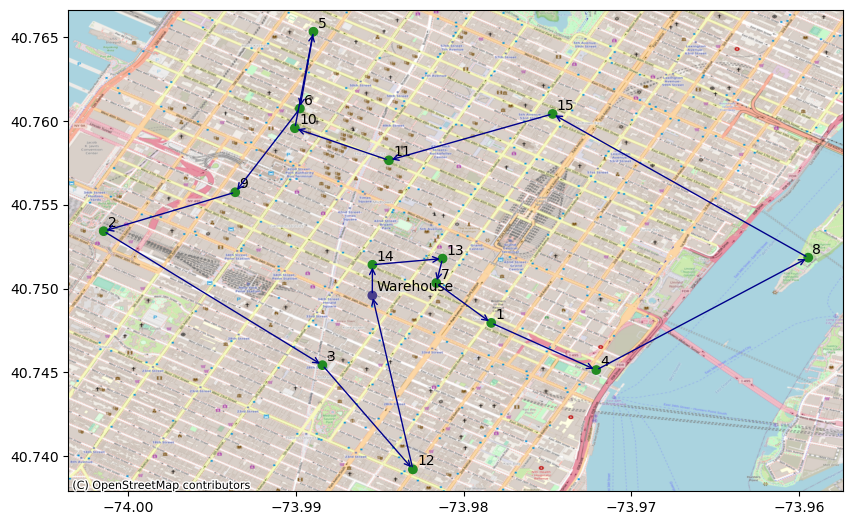

In [22]:
## Produce map of optimal route

f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    #source=contextily.providers.Stamen.Watercolor,
    source=contextily.providers.OpenStreetMap.Mapnik,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")
    
# Plot the optimal route between stops
routes = [(i, j) for i in range(customers+1) for j in range(customers+1) if pulp.value(x[i, j]) == 1]

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='darkblue')

for i, j in routes:
    ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    

plt.show()

---

### 2.2 Single Vehicle Routing Problem (VRP)

* if sigle vehicle, problem is identical to TSP

#### Add additional problem parameters
* __number of vehicles__
* __demand__: indicates the number of products each customer wants

In [23]:
# Additional Problem Parameters
vehicles = 1

# Adding simulated demand to the dataset
demand = np.random.randint(2,12,customers).tolist()
demand = [0] + demand
data_gdf['customer_demand'] = demand

data_gdf.head()                          

Label   latitude  longitude         colors                    geometry  \
0  Warehouse  40.749587 -73.985441  darkslateblue  POINT (-73.98544 40.74959)   
1          1  40.747949 -73.978350    forestgreen  POINT (-73.97835 40.74795)   
2          2  40.753419 -74.001454    forestgreen  POINT (-74.00145 40.75342)   
3          3  40.745431 -73.988416    forestgreen  POINT (-73.98842 40.74543)   
4          4  40.745141 -73.972089    forestgreen  POINT (-73.97209 40.74514)   

                                  coord  customer_demand  
0                  40.749587,-73.985441                0  
1  40.74794933872412,-73.97834956527527                4  
2  40.75341854670446,-74.00145409847728               11  
3  40.74543149027954,-73.98841574029711                9  
4   40.74514115756522,-73.9720887975238                7

#### Set up problem in PuLP

In [24]:
# Setting up the PuLP Solver
for vehicles in range(1, vehicles+1):
    
    # Linear Programming Problem
    lp_problem = pulp.LpProblem("VRP", pulp.LpMinimize)
    
    # Defining problem variables which are binary
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None 
           for k in range(vehicles)] 
          for j in range(customers+1)] 
         for i in range(customers+1)]


    
    # Setting the objective function
    lp_problem += pulp.lpSum(dist_int[i][j] * x[i][j][k] if i != j else 0
                             for k in range(vehicles)
                             for j in range(customers+1)
                             for i in range(customers+1))


    
    # Adding in the constraints
    for j in range (1, customers+1):
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customers+1) for k in range(vehicles)) == 1
    
    for k in range(vehicles):
        lp_problem += pulp.lpSum(x[0][j][k] for j in range(1, customers+1)) == 1
        lp_problem += pulp.lpSum(x[i][0][k] for i in range(1, customers+1)) == 1
    
    for k in range(vehicles):
        for j in range(customers+1):
            lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customers+1)) - pulp.lpSum(x[j][i][k] for i in range(customers+1)) == 0


    # Adding additional constraint to prevent subtours. We'll use DFJ formulation here.
    subtours = []
    for i in range(2, customers+1):
        subtours += itertools.combinations(range(1, customers+1), i)
    for s in subtours:
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicles)) <= len(s) -1

    if lp_problem.solve() == 1:
        print('# Required Vehicles:',vehicles)
        print('Distance:',pulp.value(lp_problem.objective))
        break

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/a3b38f50b13f4a489df4d934da61c2b3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/a3b38f50b13f4a489df4d934da61c2b3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 32790 COLUMNS
At line 1754566 RHS
At line 1787352 BOUNDS
At line 1787593 ENDATA
Problem MODEL has 32785 rows, 240 columns and 1721055 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 31659.5 - 0.17 seconds
Cgl0004I processed model has 32785 rows, 240 columns (240 integer (240 of which binary)) and 1721055 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 10 integers unsatisfied su

Solution to single VRP is identical to TSP, despite using different formulations.

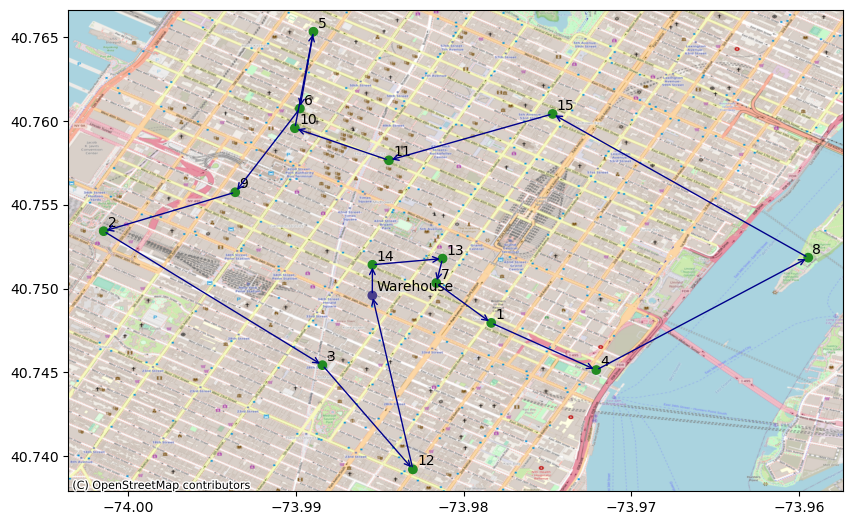

In [25]:
## Plot optimal route

f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    #source=contextily.providers.Stamen.Watercolor,
    source=contextily.providers.OpenStreetMap.Mapnik,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")


# Plot the optimal route between stops
routes = [(k, i, j) for k in range(vehicles) for i in range(customers+1) for j in range(customers+1) if i != j and pulp.value(x[i][j][k]) == 1]

arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='darkblue')

for k, i, j in routes:
    ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)

plt.show()

In [26]:
# Count the total amount of demand
data_gdf['customer_demand'].sum()

85

Are 85 packages for one vehicle realistic?

---

### 2.3 Capacitated Vehicle Routing Problem (CVRP)

* assume that vehicle can only load 40 packages at a time
* need to find optimal path and optimal number of vehicles needed
* assume company has 5 vehicles, each with capacity of 40 packages

In [27]:
# Additional Problem Parameters
vehicles = 5
capacity = 40                 

In [28]:
# Setting up the PuLP Solver

for vehicles in range(1, vehicles+1):
    
    # Linear Programming Problem
    lp_problem = pulp.LpProblem("CVRP", pulp.LpMinimize)
    
    # Defining problem variables which are binary
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None 
           for k in range(vehicles)] 
          for j in range(customers+1)] 
         for i in range(customers+1)]
    
    # Setting the objective function
    lp_problem += pulp.lpSum(dist_int[i][j] * x[i][j][k] if i != j else 0
                             for k in range(vehicles)
                             for j in range(customers+1)
                             for i in range(customers+1))
    
    # Adding in the constraints
    for j in range (1, customers+1):
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i in range(customers+1) for k in range(vehicles)) == 1
    
    for k in range(vehicles):
        lp_problem += pulp.lpSum(x[0][j][k] for j in range(1, customers+1)) == 1
        lp_problem += pulp.lpSum(x[i][0][k] for i in range(1, customers+1)) == 1
    
    for k in range(vehicles):
        for j in range(customers+1):
            lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                 for i in range(customers+1)) - pulp.lpSum(x[j][i][k] for i in range(customers+1)) == 0
    
    # Adding in the capacity constraint
    for k in range(vehicles):
        #lp_problem += pulp.lpSum(data.customer_demand[j] * x[i][j][k] if i != j else 0 for i in range(customers+1) for j in range (1,customers+1)) <= capacity
        lp_problem += pulp.lpSum(data_gdf.customer_demand[j] * x[i][j][k] if i != j else 0 for i in range(customers+1) for j in range (1,customers+1)) <= capacity
    
    
    # Adding additional constraint to prevent subtours. We'll use DFJ formulation here.
    subtours = []
    for i in range(2, customers+1):
        subtours += itertools.combinations(range(1, customers+1), i)
    for s in subtours:
        lp_problem += pulp.lpSum(x[i][j][k] if i != j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicles)) <= len(s) -1

    if lp_problem.solve() == 1:
        print('# Required Vehicles:',vehicles)
        print('Distance:',pulp.value(lp_problem.objective))
        break


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/1a40bcf7e336403db501b5faaf97ec8c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/1a40bcf7e336403db501b5faaf97ec8c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 32791 COLUMNS
At line 1754792 RHS
At line 1787579 BOUNDS
At line 1787820 ENDATA
Problem MODEL has 32786 rows, 240 columns and 1721280 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.15 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.53   (Wallclock seconds):       0.59

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sa

We need 3 vehicles that travel a combined distance of 34km

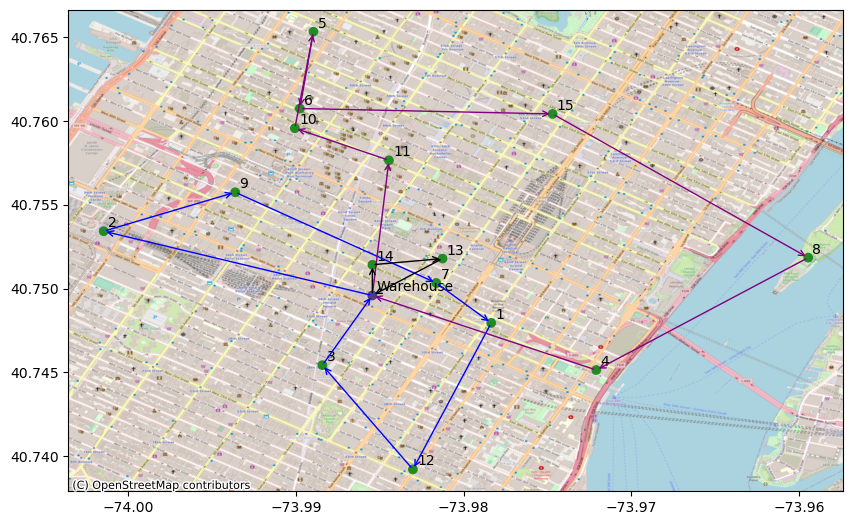

In [29]:
## Make map of route for each vehicle

f, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.plot(ax=ax,color=data_gdf['colors'])
        
# Add basemap
contextily.add_basemap(
    ax,
    crs=data_gdf.crs,
    #source=contextily.providers.Stamen.Watercolor,
    source=contextily.providers.OpenStreetMap.Mapnik,
    zoom=16
)

for lon, lat, label in zip(data_gdf.geometry.x, data_gdf.geometry.y, data_gdf.Label):
    ax.annotate(label, xy=(lon, lat), xytext=(3, 3), textcoords="offset points")

# Plot the optimal route between stops
routes = [(k, i, j) for k in range(vehicles) for i in range(customers+1) for j in range(customers+1) if i != j and pulp.value(x[i][j][k]) == 1]

for k, i, j in routes:
    if k == 0:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    elif k==1:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='purple')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
    else:
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='black')
        ax.annotate('', xy=[data_gdf.iloc[j].geometry.x, data_gdf.iloc[j].geometry.y], xytext=[data_gdf.iloc[i].geometry.x, data_gdf.iloc[i].geometry.y], arrowprops=arrowprops)
         
# Display the plot       
plt.show()

Vehicle 3 travels to fewer points that are much closer together. In the real world this would have potential negative implications on staffing. Can add more constraints to solve real world problems.